In [2]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np
from tkinter import Tk

### Finding contours of each shape

In [3]:
circle = cv2.imread("media/circle.png",1)
triangle = cv2.imread("media/triangle.jpg",1)
square = cv2.imread("media/square.png",1)
rectangle = cv2.imread("media/rect1.jpeg",1)
star = cv2.imread("media/star.jpg",1)
polygon = cv2.imread("media/polygon.jpg",1)

In [4]:
all_shapes = [circle,triangle,square,rectangle,star,polygon]

shape_names = ["Circle","Triangle","Square","Rectangle","Star","Polygon"]

all_contours = []

In [5]:
#for plotting figure
rows = int(len(all_shapes)/3)

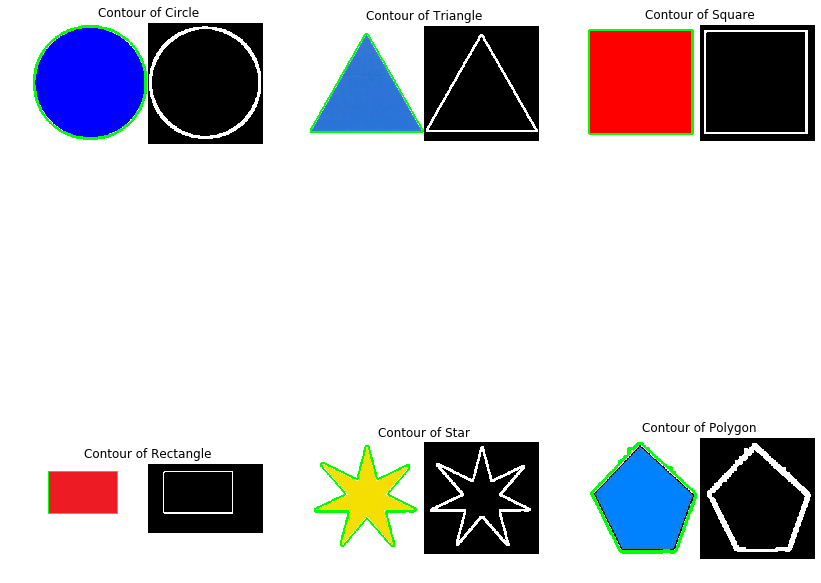

In [6]:
plt.figure(figsize=[14,14])

for index,shape in enumerate(all_shapes):
    
    img = cv2.Canny(shape,50,200)
    
    img = cv2.dilate(img,None,iterations=2)
    
    contours,hierarchy = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
        
    cnt = max(contours, key=cv2.contourArea)
        
    cv2.drawContours(shape,[cnt],0,(0,255,0),4)
        
    all_contours.append(cnt)
        
    mask = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    
    stacked = np.hstack((shape,mask))
    
    plt.subplot(rows,3,index+1)
    plt.imshow(stacked[...,::-1])
    plt.title("Contour of {}".format(shape_names[index]))
    plt.axis("off")

### Loading test image and finding contour

(-0.5, 97.5, 105.5, -0.5)

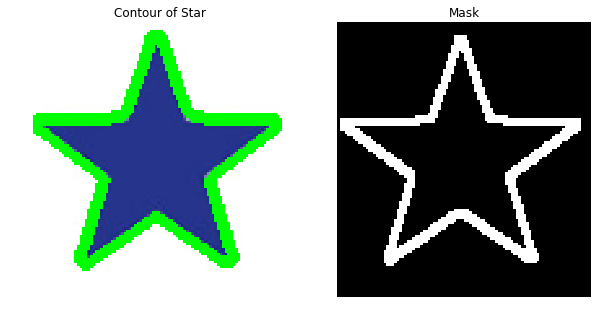

In [7]:
test_img = cv2.imread("media/star1.png",1)
org = test_img.copy()
test_2 = test_img.copy()

test_img = cv2.Canny(test_img,100,300)

test_img = cv2.dilate(test_img,None,iterations=1)
    
contours,hierarchy = cv2.findContours(test_img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
        
test_cnt = max(contours,key=cv2.contourArea)
        
cv2.drawContours(org,[test_cnt],0,(0,255,0),3)
                
mask = cv2.cvtColor(test_img,cv2.COLOR_GRAY2BGR)

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(org[...,::-1])
plt.title("Contour of Star")
plt.axis("off")

plt.subplot(122)
plt.imshow(mask,cmap="gray")
plt.title("Mask")
plt.axis("off")

### Matching test shape contour with contours of all shapes

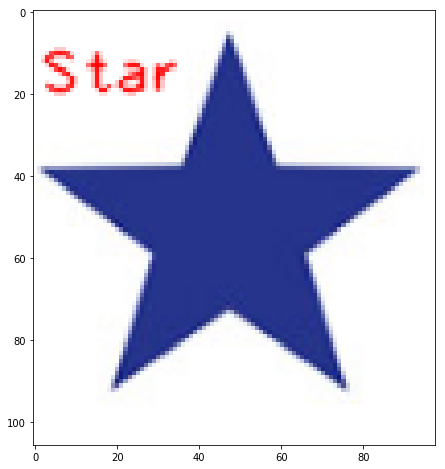

In [8]:
scores = []

for cnt in all_contours:
    
    score = cv2.matchShapes(test_cnt,cnt,1,0.0)
    scores.append(score)
    
    ind = np.argmin(np.array(scores))
    best_score = min(scores)
    
    #setting a threshold to rule out options
    min_threshold = 0.1
    
    if best_score < min_threshold:
        
        matched_shape = shape_names[ind]
        
    else:
        
        matched_shape = "Unknown"
        
cv2.putText(test_2,matched_shape,(1,20),cv2.FONT_HERSHEY_PLAIN,1,(0,0,255),1,cv2.LINE_AA)
    
plt.figure(figsize=[8,8])
plt.imshow(test_2[...,::-1])

### Function for Shape Prediction

In [11]:
from tkinter.filedialog import askopenfilename

def shape_predictor(test_img = None, display=True,thresh = 0.1):
    
    if test_img is None:
        Tk().withdraw()
        file = askopenfilename()
        test_img = cv2.imread(file)
        
    original = test_img.copy()
    
    mask = cv2.Canny(test_img,100,300)

    mask = cv2.dilate(mask,None,iterations = 1)

    contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

    if contours:
        for test_contour in contours:

            scores=[]

            for cnt in all_contours:
                score = cv2.matchShapes(test_contour,cnt,1,0.0)
                scores.append(score)

            pos = np.argmin(np.array(scores))

            finalscore = min(scores)

            if finalscore < thresh:
                label = shape_names[pos]
                x,y,w,h = cv2.boundingRect(test_contour)
                cv2.rectangle(test_img,(x,y),(x+w,y+h),(0,255,0),3)

            else:
                label = 'Unknown Shape'
                x,y,w,h = cv2.boundingRect(test_contour)
                cv2.rectangle(test_img,(x,y),(x+w,y+h),(0,0,255),3)

            cv2.putText(test_img, label, (x,y+h+16), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,255))
        
    else:
        return None

# if display is true then plot the image
        
    if display:
        plt.figure(figsize=[14,14])
        plt.subplot(121)
        plt.imshow(original[...,::-1])
        plt.title("Original Image")
        
        plt.subplot(122)
        plt.imshow(test_img[...,::-1])
        plt.title("Shape Matched")
        
    else:
        return test_img
        

### Shape Prediction on GUI Drawing

In [29]:
drawing = False #can be toggled

cv2.namedWindow("Shape Detector")

x1 = None
x2 = 0
y1 = 0
y2 = 0

def draw_line(event,x,y,flags,param):
    
    global x1,x2,y2,drawing
    
    if event == cv2.EVENT_MOUSEMOVE:
        x2 = x
        y2 = y
        
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        
width = 800
height = 800

draw = np.zeros((height,width,3),np.uint8)

pred = np.zeros((height,width,3),np.uint8)

cv2.setMouseCallback("Shape Detector",draw_line)

while True:
    
    if drawing:
        
        if x1 is not None:
            
            pred = cv2.line(pred,(x1,y1),(x2,y2),(100,40,60),5)
            draw = cv2.line(draw,(x1,y1),(x2,y2),(100,40,60),5)
            
            x1,y1 = x2,y2
            
        else:
            x1,y1 = x2,y2
            
    else:
        
        x1 = None
        
    cv2.imshow("Shape Detector",draw)
    
    k = cv2.waitKey(1)
    if k == ord('c'):
        draw = np.zeros((height,width,3),np.uint8)
        pred = np.zeros((height,width,3),np.uint8)
        
    elif k == ord('p'):
        draw = shape_predictor(pred.copy(),display=False)
        
    elif k == ord('e'):
        break
        
cv2.destroyAllWindows()
    
        
